In [40]:
%matplotlib inline
import GEOparse
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import decomposition
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import explained_variance_score, plot_roc_curve
import statsmodels.api as sm
from scipy.stats import ttest_ind
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import matplotlib
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

geo = "GSE111803"

In [41]:
data = pd.read_csv("../Dataset/Yao2020/data.txt", sep="\t")

In [42]:
data.columns

Index(['miRNA_ID', 'LC11.readcount', 'LC3.readcount', 'LC4.readcount',
       'LC5.readcount', 'LC6.readcount', 'NC1.readcount', 'NC2.readcount',
       'NC3.readcount', 'NC4.readcount', 'NC5.readcount', 'LC11.tpm',
       'LC3.tpm', 'LC4.tpm', 'LC5.tpm', 'LC6.tpm', 'NC1.tpm', 'NC2.tpm',
       'NC3.tpm', 'NC4.tpm', 'NC5.tpm'],
      dtype='object')

In [43]:
table = data.iloc[:, 11:].transpose()
mirnas = data.iloc[:, 0]
table

,0,1,2,3,4,5,6,7,8,9,...,1244,1245,1246,1247,1248,1249,1250,1251,1252,1253
LC11.tpm,84.810449,35945.49515,2.019296,6601.079920,0.000000,1524.568779,438.187318,6187.124158,2.019296,448.283800,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.019296,0.000000,0.000000
LC3.tpm,81.564623,24061.56385,8.718977,4780.811951,0.000000,1379.004647,408.385631,5804.307343,0.843772,542.545373,...,0.281257,0.562515,1.687544,0.562515,0.281257,0.281257,0.281257,0.281257,0.000000,0.000000
LC4.tpm,116.614493,34847.67075,8.150475,5837.621215,0.626960,1502.822259,378.683623,8105.961195,0.626960,750.470690,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
LC5.tpm,91.876345,28593.96015,15.312724,10165.096690,0.000000,1686.951773,579.331395,5576.383696,0.000000,201.617534,...,2.552121,2.552121,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
LC6.tpm,81.566355,33601.82989,21.049382,11863.080790,0.000000,1524.326069,504.308107,6267.453446,3.508230,366.610067,...,0.000000,0.000000,2.631173,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
NC1.tpm,57.658187,27294.59926,6.552067,4589.067484,0.000000,794.110478,517.613266,5409.386229,5.241653,681.414932,...,1.310413,0.000000,0.000000,0.000000,1.310413,0.000000,0.000000,0.000000,0.000000,1.310413
NC2.tpm,60.758241,23345.52549,5.523476,4267.437891,0.000000,1277.027751,407.632561,4757.922598,0.000000,269.545650,...,0.000000,0.000000,0.000000,0.000000,2.209391,4.418781,0.000000,0.000000,0.000000,1.104695
NC3.tpm,65.481015,27197.75136,2.931986,3570.181314,0.000000,1040.854941,397.446957,5409.187931,0.651552,430.350353,...,0.977329,0.325776,0.000000,0.000000,0.000000,0.325776,0.000000,0.325776,0.325776,0.000000
NC4.tpm,53.163034,25408.60776,9.968069,5724.994268,0.000000,1162.941378,348.882413,4113.489788,0.000000,624.665654,...,3.322690,0.000000,0.000000,3.322690,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
NC5.tpm,97.619309,24992.46983,2.568929,4310.663175,0.642232,1364.743631,474.609667,4970.235744,1.284465,880.500479,...,1.284465,0.642232,0.642232,0.000000,0.642232,0.642232,0.000000,0.000000,0.000000,0.000000


In [44]:
controls = np.array(["NC" in c for c in table.index])
sick = 1 - controls

### Mean-variance-plot

In [45]:
np.mean(table)

0          79.111205
1       28528.947349
2           8.279538
3        6171.003470
4           0.126919
            ...     
1249        0.566805
1250        0.028126
1251        0.262633
1252        0.032578
1253        0.241511
Length: 1254, dtype: float64

In [46]:
def get_means_and_variances(table):
    return np.mean(table), np.var(table, ddof=1)

In [47]:
def mean_variance_plot(table):
    means, variances = get_means_and_variances(table)
    plt.scatter(means, variances)
    plt.xlabel("mean")
    plt.ylabel("variance")
    plt.plot()

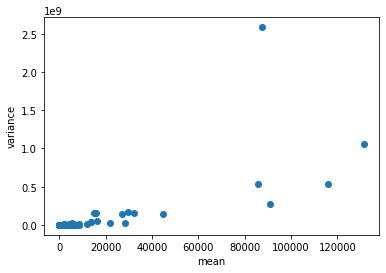

In [48]:
mean_variance_plot(table)

### Log transformation

In [49]:
log_table = np.log2(table + 1e-6)

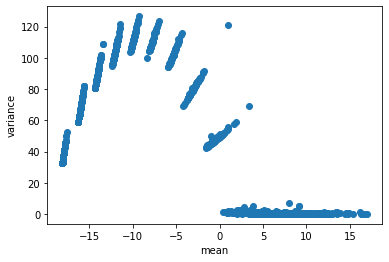

In [50]:
mean_variance_plot(log_table)

In [51]:
mask = log_table.var() < 20
log_table = log_table.loc[:, mask]
mirnas = mirnas[mask]

### Standardizing

In [52]:
norm_log_table = log_table - np.mean(log_table)

In [53]:
norm_log_table /= np.sqrt(np.mean(np.var(norm_log_table, ddof=1)))

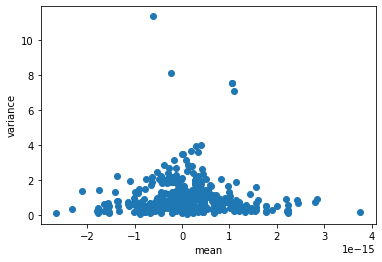

In [54]:
mean_variance_plot(norm_log_table)

In [55]:
norm_log_table.isna().sum().sum()

0

### PCA

In [56]:
pca = decomposition.PCA(n_components=10)

In [57]:
pca.fit(norm_log_table)

PCA(n_components=10)

In [58]:
pca.explained_variance_ratio_

array([3.65562912e-01, 1.61406799e-01, 1.21797075e-01, 9.30153938e-02,
       7.66735956e-02, 6.81135237e-02, 5.00614371e-02, 4.19009991e-02,
       2.14682647e-02, 1.45550800e-32])

In [59]:
components = pca.transform(norm_log_table)

In [60]:
components

array([[-1.06000228e+01, -8.97777945e+00, -2.26750013e+00,
        -9.64731144e+00, -8.84307388e-01,  7.22301510e+00,
        -5.21457761e+00,  7.57585971e-01, -1.26496132e-01,
         3.21964677e-15],
       [ 1.08632556e+00,  7.49979084e+00, -3.33649190e+00,
         9.37622615e-01, -7.80921330e+00, -1.49411371e+00,
        -2.16148608e+00,  5.50926381e-01,  6.21984214e+00,
         1.36002321e-15],
       [ 7.00137811e-01,  7.76895471e+00, -7.67066016e+00,
         2.60027682e+00, -6.04075835e+00, -1.07413333e+00,
        -2.54458610e+00, -1.62487647e+00, -5.80010881e+00,
         1.99840144e-15],
       [-1.25159124e+01, -2.16155446e+00, -1.01546410e+01,
        -3.60640181e+00,  4.85191005e+00, -6.07767106e+00,
         6.51393251e+00, -9.38741868e-01,  6.78412096e-01,
         4.60742555e-15],
       [-7.94153058e+00,  1.42256567e+01,  6.90139981e+00,
        -8.55554264e-01,  3.68741764e+00,  5.77509527e+00,
         3.82762688e+00,  3.99428027e+00, -6.15854829e-01,
         2.

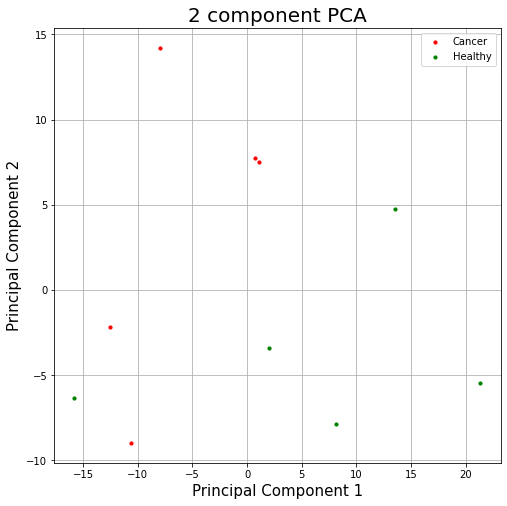

In [61]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Cancer', 'Healthy']
colors = ['r', 'g']
ax.scatter(components[controls == False, 0], components[controls == False, 1], c = 'r', s = 10)
ax.scatter(components[controls == True, 0], components[controls == True, 1], c = 'g', s = 10)
ax.legend(targets)
ax.grid()

In [63]:
components2 = components[components[:,0] < 20, :]
controls2 = controls[components[:,0] < 20]

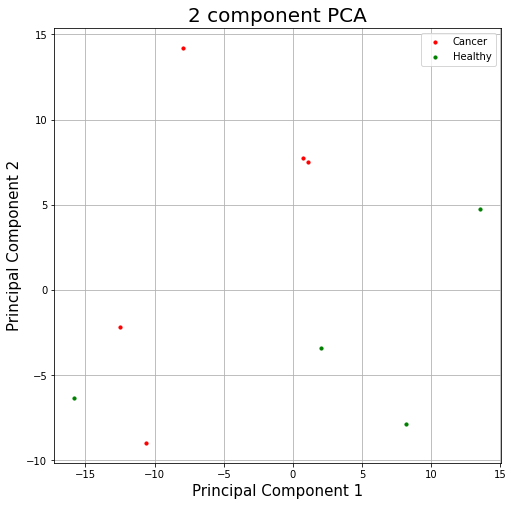

In [64]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Cancer', 'Healthy']
colors = ['r', 'g']
ax.scatter(components2[controls2 == False, 0], components2[controls2 == False, 1], c = 'r', s = 10)
ax.scatter(components2[controls2 == True, 0], components2[controls2 == True, 1], c = 'g', s = 10)
ax.legend(targets)
ax.grid()

### Logistic Regression

In [65]:
X_train, X_test, y_train, y_test = train_test_split(norm_log_table, controls, test_size=0.33, random_state=42)

In [66]:
model = LogisticRegression(max_iter=2000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=2000)

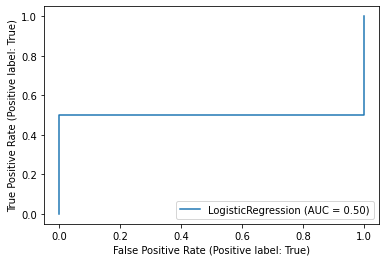

In [67]:
plot_roc_curve(model, X_test, y_test)

### XGBoost

In [68]:
X_train, X_test, y_train, y_test = train_test_split(norm_log_table, controls, test_size=0.33, random_state=42)

In [69]:
model = XGBClassifier(use_label_encoder=False)
model.fit(X_train, y_train)

[15:54:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

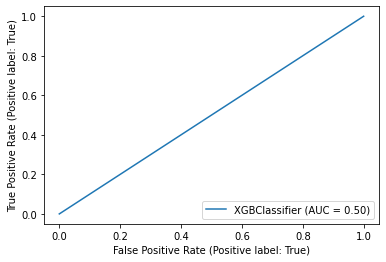

In [70]:
plot_roc_curve(model, X_test, y_test)

### Exporting data

In [71]:
mirnas[:10]

0       hsa-let-7a-3p
1       hsa-let-7a-5p
2       hsa-let-7b-3p
3       hsa-let-7b-5p
5       hsa-let-7c-5p
6       hsa-let-7d-3p
7       hsa-let-7d-5p
9       hsa-let-7e-5p
10    hsa-let-7f-1-3p
12      hsa-let-7f-5p
Name: miRNA_ID, dtype: object

In [72]:
from Scripts import converters

In [73]:
sequences = converters.canonical_to_seq(mirnas, True)

In [74]:
sequences = np.array(sequences)

In [75]:
mirnas[sequences == None]

1187    novel_179
1208    novel_324
Name: miRNA_ID, dtype: object

In [76]:
mask = sequences != None
sequences = sequences[mask]
norm_log_table = norm_log_table.loc[:, mask]

In [77]:
norm_log_table.columns = sequences
norm_log_table["cancer"] = sick
norm_log_table.head()

,CUAUACAAUCUACUGUCUUUC,UGAGGUAGUAGGUUGUAUAGUU,CUAUACAACCUACUGCCUUCCC,UGAGGUAGUAGGUUGUGUGGUU,UGAGGUAGUAGGUUGUAUGGUU,CUAUACGACCUGCUGCCUUUCU,AGAGGUAGUAGGUUGCAUAGUU,UGAGGUAGGAGGUUGUAUAGUU,CUAUACAAUCUAUUGCCUUCCC,UGAGGUAGUAGAUUGUAUAGUU,...,CACCCGGCUGUGUGCACAUGUGC,UCUUCUCUGUUUUGGCCAUGUG,UUCAACGGGUAUUUAUUGAGCA,UCUUUGGUUAUCUAGCUGUAUGA,UUUGGCACUAGCACAUUUUUGCU,UGAGGUAGUAAGUUGUAUUGUU,AACCCGUAGAUCCGAUCUUGUG,CAAGCUCGUGUCUGUGGGUCCG,CACCCGUAGAACCGACCUUGCG,cancer
LC11.tpm,0.177456,0.437284,-2.095874,0.254377,0.289674,-0.009385,0.188157,-0.104962,0.637302,0.425734,...,0.068298,-0.011440,1.490292,-0.296643,-0.895648,0.600075,1.010940,-0.781499,-0.262884,1
LC3.tpm,0.107082,-0.286583,0.542067,-0.327444,0.108703,-0.136407,0.072973,0.239210,-0.076304,-0.301775,...,-0.227751,-0.145099,0.278488,0.015971,-0.890515,-0.304976,-0.319197,0.318697,-0.187948,1
LC4.tpm,0.751761,0.381347,0.420471,0.032720,0.263765,-0.272584,0.675310,0.824288,-0.378895,0.186420,...,-0.310141,0.362533,-1.350235,0.367141,0.342709,0.177769,-1.114146,-0.014280,-0.282436,1
LC5.tpm,0.321774,0.024649,1.557715,1.032957,0.472200,0.494178,0.000728,-1.545984,-0.921631,-0.642132,...,-0.143102,0.826603,1.181386,1.114960,1.249844,0.446369,0.471070,-2.216010,-0.845027,1
LC6.tpm,0.107120,0.315693,2.131537,1.311532,0.289387,0.244068,0.211420,-0.467678,1.845849,-0.589484,...,0.295246,0.374556,-0.744848,-1.370611,1.989233,0.026971,-0.512990,0.455449,0.011539,1


In [78]:
norm_log_table.to_csv("../TransformedData/Yao2020.csv", index=False)